In [100]:
import numpy as np
import nltk
from nltk.corpus import brown, wordnet as wn, gutenberg
from nltk.stem import WordNetLemmatizer
import gensim
import re
import string
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS

In [89]:
# nltk.download('brown')
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [181]:
lemmatizer = WordNetLemmatizer()

def filter(token):
    result = not re.search("[{}\d]".format(string.punctuation), token)
#     result &= len(wn.synsets(token)) != 0
    return result

def replace_token(token):
    token = lemmatizer.lemmatize(token, "v")
    token = lemmatizer.lemmatize(token)
    return token

def get_sentences(sentences):
    sentences = [[replace_token(token.lower()) for token in sent] for sent in sentences]
    sentences = [[token for token in sent if filter(token)] for sent in sentences]
    return sentences

def plot_clusters(clusters, index2vector, index2word, num_per_cluster = 10, ):
    # plot clusters without regard to similarity

    # number of words to show per cluster
    num_per_cluster = 10

    plt.figure(figsize = (25,25))

    # choose as many random colors as their are clusters
    colors = np.random.choice(np.array(list(mcolors.TABLEAU_COLORS.items()))[:, 0], len(clusters), replace = True)

    # go through all clusters
    for i, cluster in enumerate(clusters[:]):
        # select color
        color = colors[i]
        # choose random words to display
        random_instances = np.random.choice(cluster, min(len(cluster), num_per_cluster), replace = False)

        # list/iterator of words that exist in word net
        wn_words = [word for word in index2word[random_instances] if len(wn.synsets(word)) != 0]
        wn_words = iter(wn_words)
        # the lowest common subsumer of the words in a cluster
        common_hypernym = None
        for word in wn_words:
            # if lcs is not set yet, find lcs of current word and next word in the iterator
            if common_hypernym is None:
                try:
                    common_hypernyms = wn.synsets(word)[0].lowest_common_hypernyms(wn.synsets(next(wn_words))[0])
                except:
                    break
            # otherwise, find lcs of current lcs and current word
            else:
                common_hypernyms = wn.synsets(word)[0].lowest_common_hypernyms(common_hypernym)

            # if at least 1 lcs was found, set the first one as the current lcs
            if len(common_hypernyms) != 0:
                common_hypernym = common_hypernyms[0]

        # display the randomly chosen words of the current cluster and create a legend for the cluster with the lcs as label
        for i, (x,y) in enumerate(index2vector[random_instances]):
            if i == 0:
                plt.scatter(x, y, color = color, label = str(common_hypernym))
            else:
                plt.scatter(x, y, color = color)

            # annotate every word
            plt.annotate(index2word[random_instances[i]],
                        xy = (x,y),
                        xytext=(5,2),
                        textcoords="offset points",
                        ha="right",
                        va="bottom")


    plt.legend()
    plt.savefig("embeddings.png")
    plt.show()
    
def get_kmeans_clusters(n_clusters, vectors):
    # obtain clusters with kmeans
    kmeans = KMeans(n_clusters = n_clusters).fit(vectors)
    clusters = [np.array([i for i, cluster in enumerate(kmeans.labels_) if cluster == j]) 
                for j in range(min(kmeans.labels_), max(kmeans.labels_) + 1)]
    return clusters
    
def get_dbscan_clusters(eps, min_samples, vectors):
    # obtain clusters with dbscan
    dbscan = DBSCAN(eps = eps, min_samples = min_samples).fit(vectors)
    clusters = [np.array([i for i, cluster in enumerate(dbscan.labels_) if cluster == j]) 
                for j in range(min(dbscan.labels_), max(dbscan.labels_) + 1)]
    print("Number of dbscan clusters: ", len(clusters))
    return clusters

def get_optics_clusters(min_samples, max_eps, vectors):
    # obtain clusters with optics
    optics = OPTICS(min_samples = min_samples, max_eps = max_eps).fit(vectors)
    clusters = [np.array([i for i, cluster in enumerate(optics.labels_) if cluster == j]) 
                for j in range(min(optics.labels_), max(optics.labels_) + 1)]
    print("Number of optics clusters: ", len(clusters))
    return clusters

In [68]:
# brown corpus sentences
sentences = get_sentences(brown.sents(categories = ["romance", "adventure", "science_fiction", "mystery"]))

In [3]:
# gutenberg corpus sentences
sentences = get_sentences(gutenberg.sents("austen-emma.txt"))

In [4]:
# train word2vec model on a set of sentences
word2vec = gensim.models.Word2Vec(sentences, size = 50, iter = 500, min_count = 10, window = 10, negative = 5)
word2vec.save("word2vec.model")

[0.08847566 0.07616815]
Number of optics clusters:  15


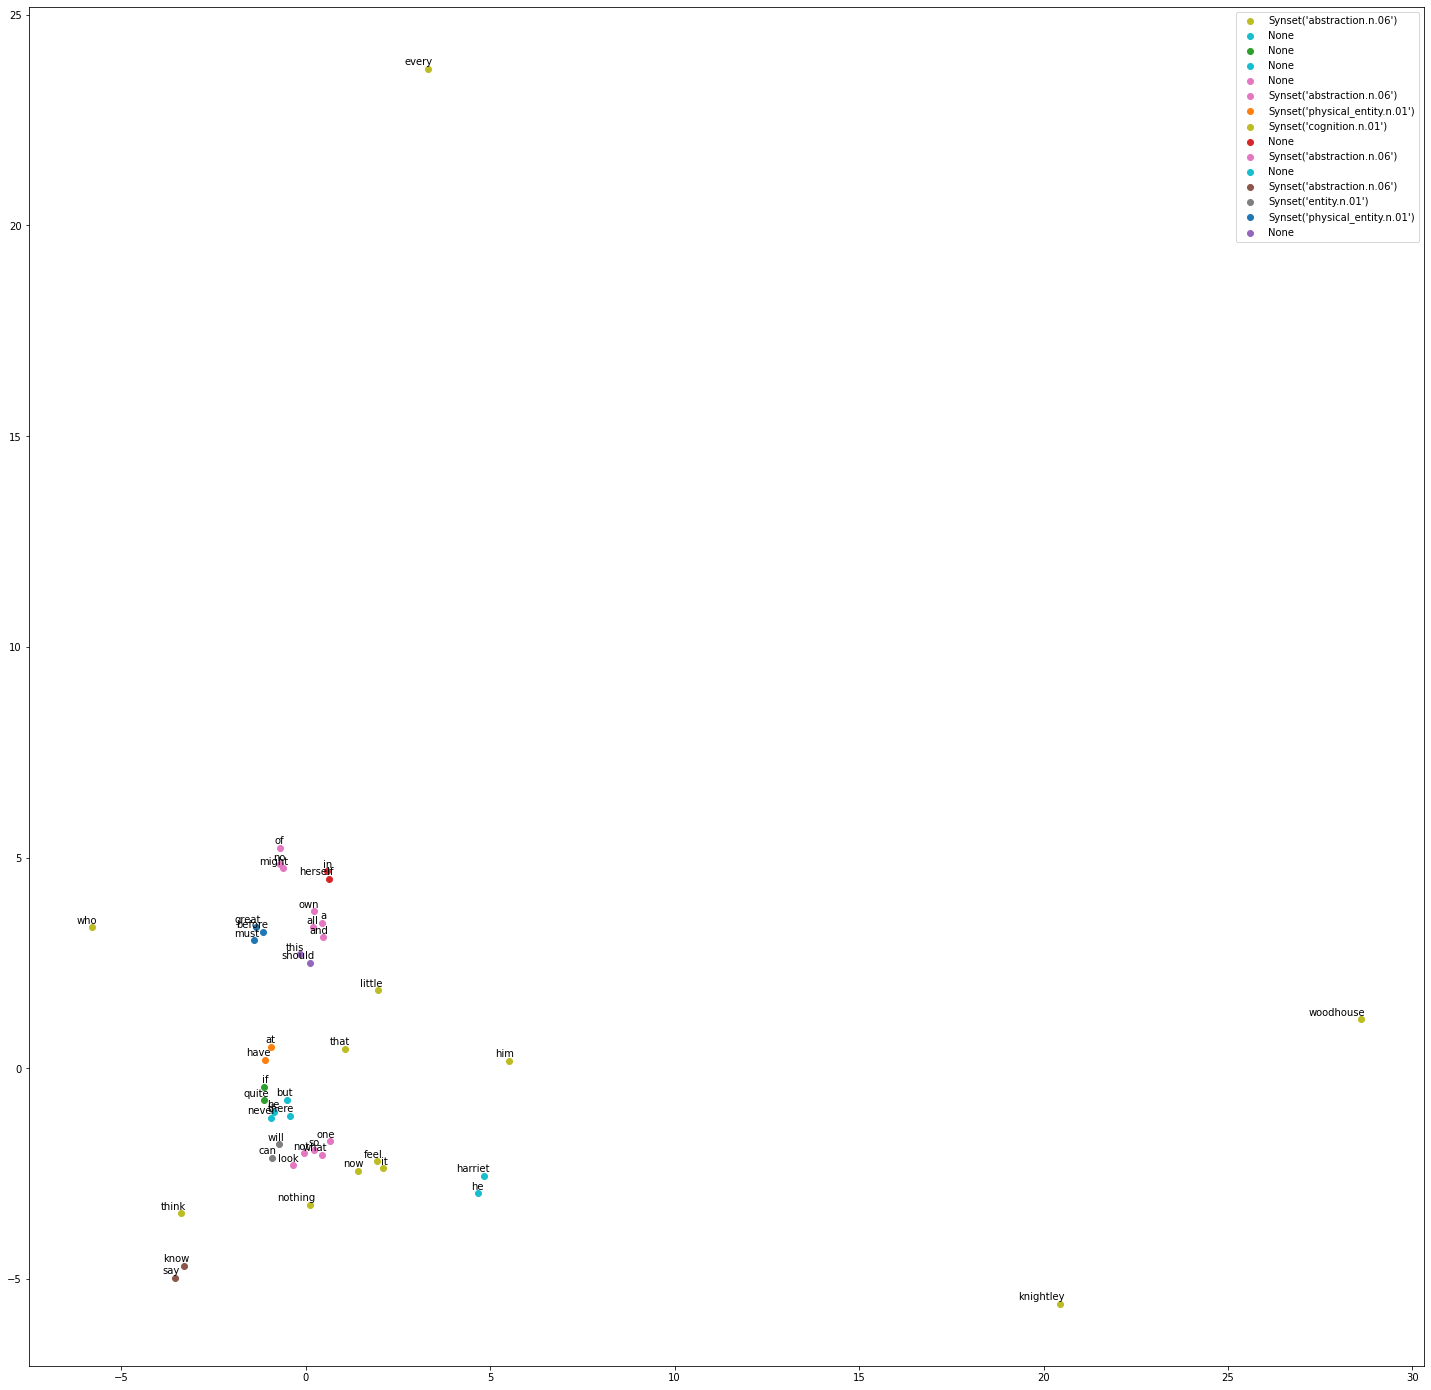

In [186]:

index2word = np.array(word2vec.wv.index2word)[:100]
word2index = {word: index for index, word in enumerate(index2word)}
index2vector = np.array(word2vec.wv.vectors)[:100]

pca = PCA(n_components = 2)
pca.fit(index2vector)
print(pca.explained_variance_ratio_)
index2vector = np.matmul(index2vector, np.transpose(pca.components_))

clusters = get_optics_clusters(2, .5, index2vector)

plot_clusters(clusters, index2vector, index2word)

Number of optics clusters:  21
[0.18160246 0.10724092]


C:\Users\robin\anaconda3\envs\text-mining\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


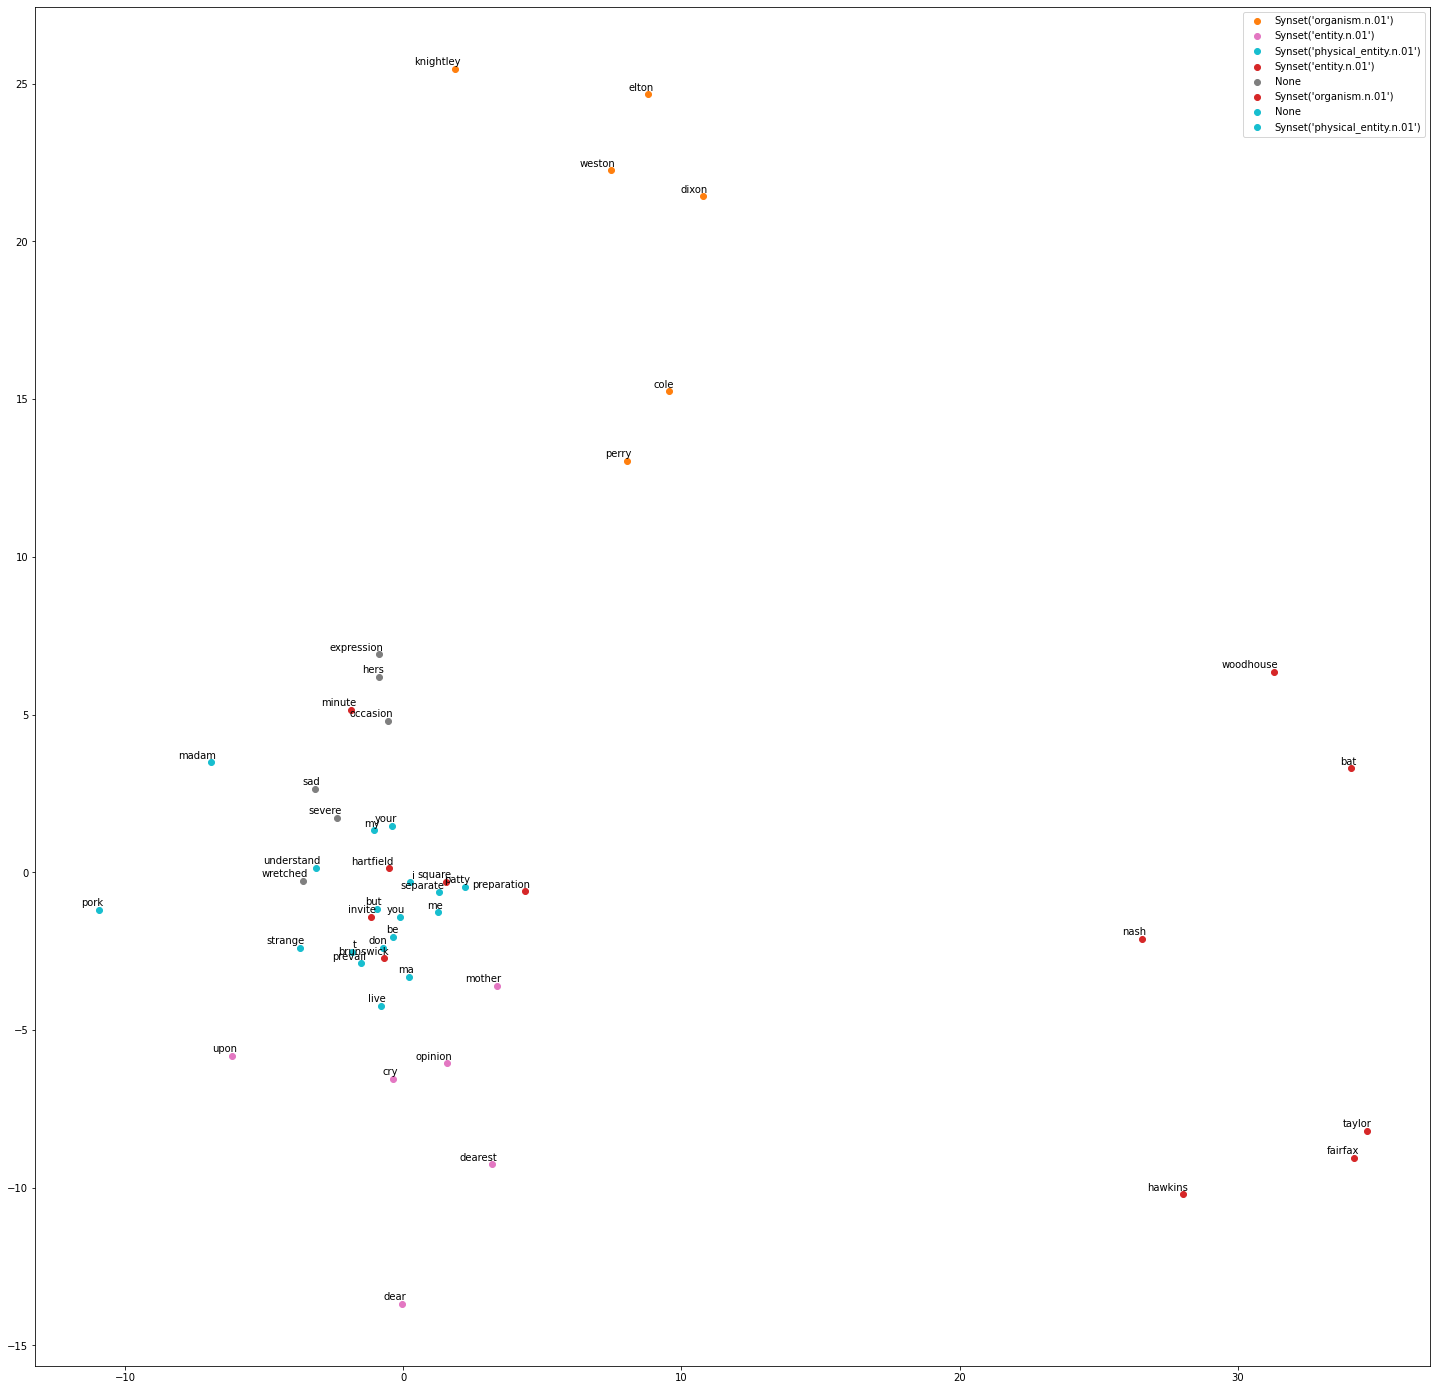

In [190]:
# obtain clusters by 
# 1) obtaining initial clusters of the embedding space with kmeans
# 2) obtaining the most frequent word of these clusters
# 3) obtaining similiarity clusters by putting every most frequent word together with its n most similar word
# 4) obtaining 2d embeddings by applying pca to the words in the sim. clusters

index2word = np.array(word2vec.wv.index2word)
word2index = {word: index for index, word in enumerate(index2word)}
index2vector = np.array(word2vec.wv.vectors)
    
# first, obtain clusters from the initital word2vec vectors
initial_clusters = get_optics_clusters(2, 40.0, index2vector)
# get the most frequent (smallest index) word from every cluster
instance_per_cluster = [min(cluster) for cluster in np.random.choice(initial_clusters, 8, replace = False)]
# for every most frequent word of a cluster, get the 10 most similar words of that word
sim_clusters = [[index] + [word2index[word] 
                           for word, _ in word2vec.wv.most_similar(positive=[index2word[index]], topn = 5)]
               for index in instance_per_cluster]
# list of indices
indices = [index for cluster in sim_clusters for index in cluster]

index2word = index2word[indices]
old_index2new_index = {old_index: new_index for new_index, old_index in enumerate(indices)}
word2index = {word: index for index, word in enumerate(index2word)}
index2vector = index2vector[indices]

# fit a pca model on the randomly sampled instances
pca.fit(index2vector)
# print explained variance ratios
print(pca.explained_variance_ratio_)
# obtain the new, 2 dimensional, word embeddings for the selected instances
index2vector = np.matmul(index2vector, np.transpose(pca.components_))

clusters = [[old_index2new_index[index] for index in cluster] for cluster in sim_clusters]
# clusters = get_kmeans_clusters(20, index2vector)


# plot the clusters
plot_clusters(clusters, index2vector, index2word, 10)

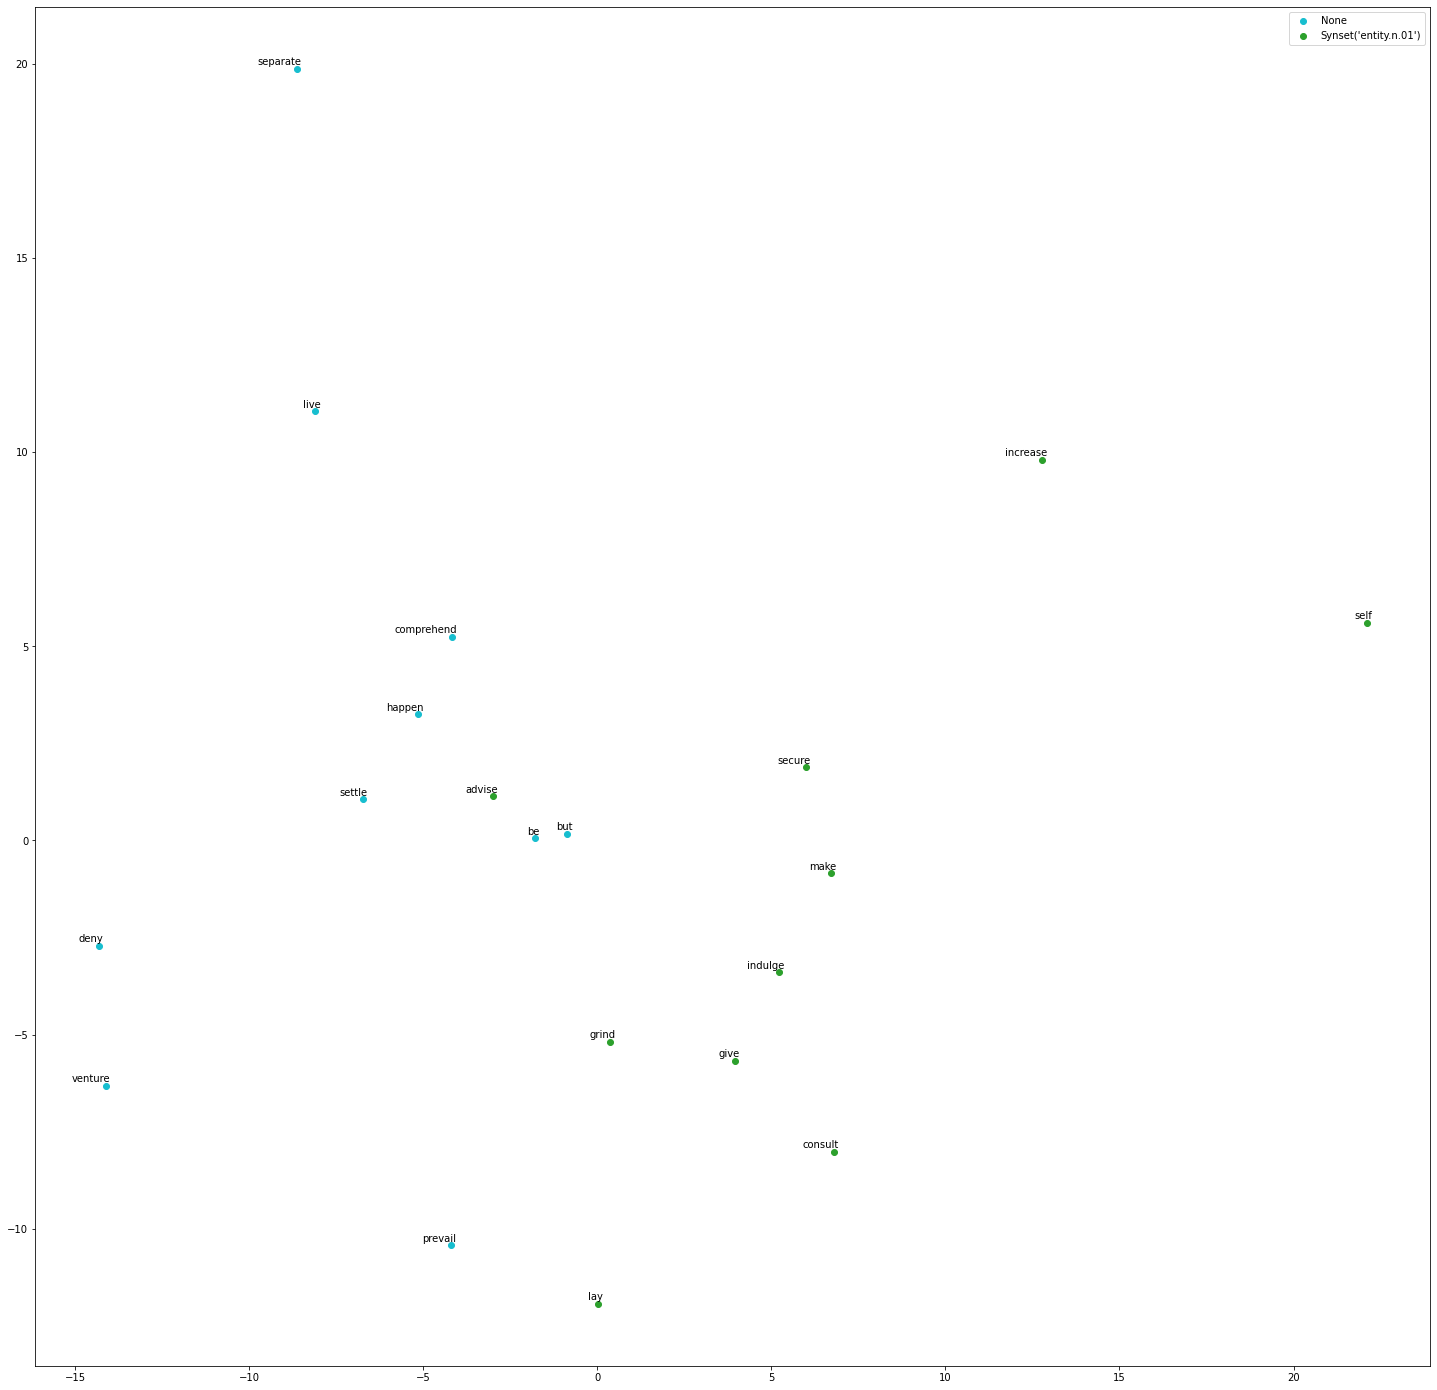

In [159]:
# obtain clusters for the 2d vectors
# clusters = get_dbscan_clusters(0.9, 3, index2vector)
# clusters = get_kmeans_clusters(20, index2vector)

clusters = [[old_index2new_index[index] for index in cluster] for cluster in sim_clusters]

# plot the clusters
plot_clusters(clusters[:2], index2vector, 10)

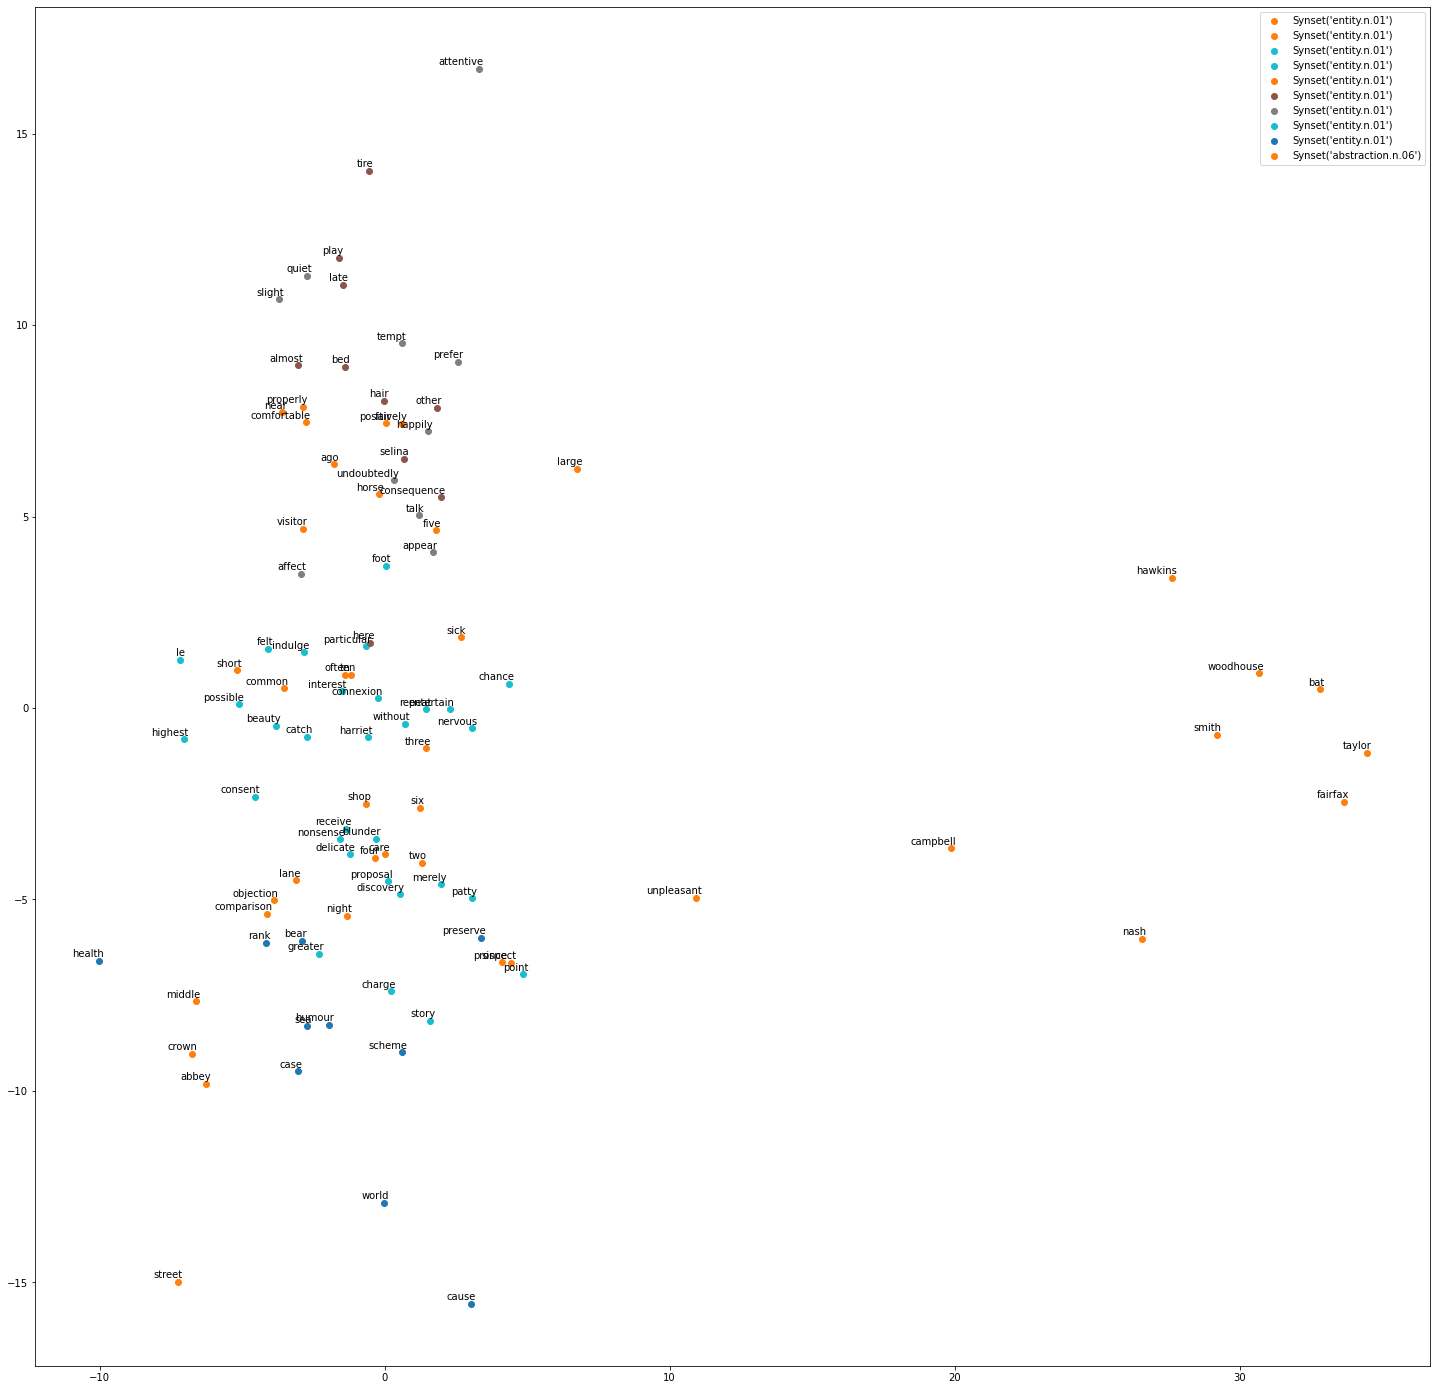

In [22]:
plot_clusters(sim_clusters, clustered_index2vector)